In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
import timeit
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10,15)
ds = sio.loadmat('face.mat')

In [2]:
X = ds['X']
l = ds['l'][0]
split = 0.8
W = 46
H = 56
IDs = 52
X = pd.DataFrame(X.transpose())
N = X.shape[0]*split
l = pd.DataFrame(l)

In [3]:
X_train, X_test, l_train, l_test = train_test_split(X, l, test_size=(1-split), stratify = l)
# X_bar = np.mean(X, axis=1)
X_train, X_test = X_train.values, X_test.values
l_train, l_test = l_train.values, np.transpose(l_test.values)
X_bar = np.transpose([np.mean(X_train, axis=0)])
X_bar = np.ndarray.flatten(X_bar)

In [4]:
train_subspaces = []
for i in range(IDs):
    images = []
    for j in range(int(N)):
        if l_train[j][0] == i+1:
            images.append(X_train[j])
    train_subspaces.append(images)

In [5]:
eigen_subspaces = []
elements = np.asarray(train_subspaces[0])
elements_mean = np.mean(elements, axis=0)
elements = np.subtract(elements,elements_mean)
S_W = np.matmul(elements.T,elements)
mean_diff = np.atleast_2d(elements_mean)-X_bar
S_B = np.matmul(mean_diff.T, mean_diff)
S = np.matmul(elements,np.transpose(elements))
w, v = np.linalg.eig(S)
U = preprocessing.normalize(np.matmul(np.transpose(elements),v), axis=0)
eigen_subspaces.append([U,elements_mean])
for i in range(1,IDs):
    elements = np.asarray(train_subspaces[i])
    elements_mean = np.mean(elements, axis=0)
    elements = np.subtract(elements,elements_mean)
    S_W += np.matmul(elements.T,elements)
    mean_diff = np.atleast_2d(elements_mean)-X_bar
    S_B += np.matmul(mean_diff.T, mean_diff)
    S = np.matmul(elements,np.transpose(elements))
    w, v = np.linalg.eig(S)
    U = preprocessing.normalize(np.matmul(np.transpose(elements),v), axis=0)
    eigen_subspaces.append([U,elements_mean])

In [6]:
print(S_W.shape)
print(S_B.shape)

print(np.linalg.matrix_rank(S_W))
print(np.linalg.matrix_rank(S_B))
print(N-52)

(2576, 2576)
(2576, 2576)
364
51
364.0


c:\users\georg\appdata\local\programs\python\python35\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


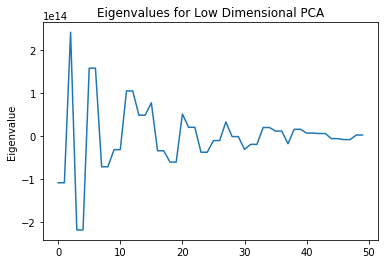

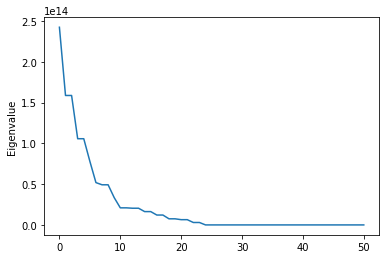

In [7]:
S_WB = np.matmul(np.linalg.inv(S_W),S_B)
w_lda, v_lda = np.linalg.eig(S_WB)
plt.plot(w_lda[:50])
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues for Low Dimensional PCA')
plt.show()

inds = w_lda.argsort()[::-1]
w_lda = w_lda[inds]
v_lda = v_lda[:,inds]
M_lda = 51
w_lda = w_lda[:M_lda]
v_lda = v_lda[:,:M_lda]


plt.plot(w_lda)
plt.ylabel('Eigenvalue')
plt.show()

(416, 416)


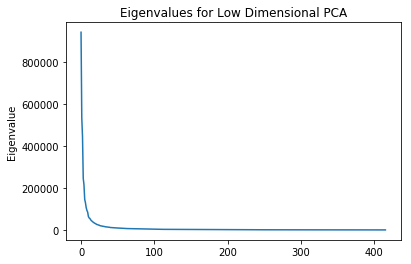

(2576, 122)


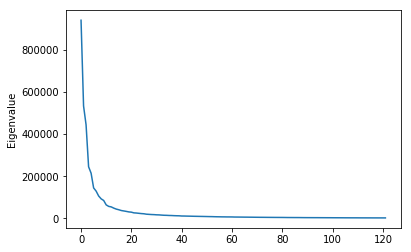

In [30]:
A = np.subtract(X_train,X_bar).T
print(np.matmul(A.T,A).shape)
w_pca, v_pca = np.linalg.eig((1/N)*np.matmul(A.T,A))
inds = w_pca.argsort()[::-1]
w_pca = w_pca[inds]
v_pca = v_pca[:,inds]
plt.plot(w_pca)
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues for Low Dimensional PCA')
plt.show()
cum_w = np.cumsum(w_pca)/np.sum(w_pca);
M_pca = np.argmax(cum_w>0.95)
w_pca = w_pca[:M_pca]
v_pca = v_pca[:,:M_pca]
v_pca = preprocessing.normalize(np.matmul(A,v_pca), axis=0)
print(v_pca.shape)
plt.plot(np.abs(w_pca))
plt.ylabel('Eigenvalue')
plt.show()

c:\users\georg\appdata\local\programs\python\python35\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


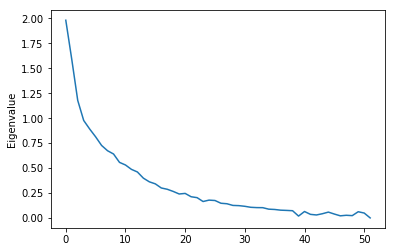

In [37]:
meh2 = np.dot(np.dot(v_pca.T,S_W),v_pca)
meh1 = np.dot(np.dot(v_pca.T,S_B),v_pca)
w_fld, v_fld = np.linalg.eig(np.linalg.inv(meh2).dot(meh1))
w_fld = w_fld[:M_lda+1]
v_fld = v_fld[:,:M_lda+1]

plt.plot(w_fld)
plt.ylabel('Eigenvalue')
plt.show()

(2576,)


c:\users\georg\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


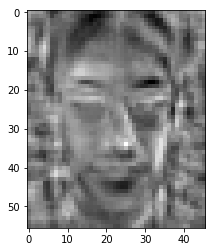

In [71]:
# v_opt = np.zeros((2576,51))
# print(v_pca.shape)
# for i in range(2576):
#     for j in range(M_pca):
# #         print(i)
# #         print(j)
#         v_opt[i,j] = v_pca[i,j]*v_lda[i,j]
v_opt = np.dot(v_pca,v_fld)
v_opt = preprocessing.normalize(v_opt,axis=0)
print(np.transpose(v_opt)[0].shape)
train_img = np.transpose(np.array_split(np.transpose(v_opt)[0], W))
imgplot = plt.imshow(train_img, cmap='gray')


In [75]:
Y_train = []
print(A.shape)
for i in range(int(N)):
    Y_train.append(np.matmul(v_opt.T,A.T[i]))
    

(2576, 416)


In [90]:
correct = 0
X_test_norm = np.subtract(X_test,X_bar)
for i in range(len(X_test)):
    y_test = np.matmul(v_opt.T,X_test_norm[i])
    diff = np.subtract(Y_train, y_test)
    value = np.argmin(np.diag(np.matmul(diff, diff.T)))
    if l_train[value] == l_test[0][i]:
        correct += 1
print(correct/len(l_test[0]))

0.8365384615384616


In [ ]:
plt.figure(figsize=(15.0,9.0))
for i in range(1,9):
    eigen = np.transpose(v_opt)[i]
    eigenface = np.real(np.transpose(np.array_split(eigen/(np.max(eigen)), W)))
    ax = plt.subplot(2,4,i)
    ax.imshow(eigenface, cmap='gray')

In [ ]:
# correct = 0
# wrong = []
# right = []
# for j in range(len(l_test[0])):
#     error = []
#     for i in range(IDs):
#         test_img = X_test[j]-eigen_subspaces[i][1]
#         identity = np.matmul(test_img,eigen_subspaces[i][0])
#         recon = np.matmul(identity, np.transpose(eigen_subspaces[i][0]))+eigen_subspaces[i][1]
#         diff = X_test[j]-recon
#         error.append(np.matmul(diff,np.transpose(diff)))
#     guess = np.argmin(error)+1
#     if guess == l_test[0][j]:
#         correct += 1
#         right.append([[l_test[0][j], j], [guess]])
#     else:
#         wrong.append([[l_test[0][j], j], [guess]])
            
# print('Correct = '+str(round(100*correct/len(l_test[0]),2))+'%')

In [ ]:
# plt.figure(figsize=(15.0,9.0))
# incorrect = wrong[0]
# guess = incorrect[1][0]-1
# train_img = np.asarray(train_subspaces[guess])[0]
# test_img = np.transpose(np.array_split(X_test[incorrect[0][1]], W))
# train_img = np.transpose(np.array_split(np.transpose(train_img), W))
# ax = plt.subplot(1, 2, 1)
# ax.imshow(test_img, cmap='gray')
# ax = plt.subplot(1, 2, 2)
# ax.imshow(train_img, cmap='gray')

In [ ]:
# plt.figure(figsize=(15.0,9.0))
# correct = right[0]
# guess = correct[1][0]-1
# train_img = np.asarray(train_subspaces[guess])[0]
# test_img = np.transpose(np.array_split(X_test[correct[0][1]], W))
# train_img = np.transpose(np.array_split(np.transpose(train_img), W))
# ax = plt.subplot(1, 2, 1)
# ax.imshow(test_img, cmap='gray')
# ax = plt.subplot(1, 2, 2)
# ax.imshow(train_img, cmap='gray')